In [45]:
# Import required libraries 
import pandas as pd
import numpy as np
# For encoding categorical variables
from sklearn.preprocessing import LabelEncoder,StandardScaler  
import imblearn
from imblearn.over_sampling import SMOTE
import json
import requests

# libraries for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import plotly.graph_objs as go
import cufflinks as cf
from plotly.offline import iplot, init_notebook_mode, plot
cf.go_offline()

# import machine learning libraries 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from poniard import PoniardClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score,roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import confusion_matrix, precision_score, plot_confusion_matrix,classification_report
from sklearn import metrics

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('C:/Users/leemn/Downloads/full_filled_stroke_data.csv')
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,31.555602,never smoked,1
1,Female,59.0,0,0,Yes,Private,Rural,76.15,30.242937,Unknown,1
2,Male,78.0,0,1,Yes,Private,Urban,219.84,30.698951,Unknown,1
3,Male,57.0,0,1,No,Govt_job,Urban,217.08,33.808410,Unknown,1
4,Male,58.0,0,0,Yes,Private,Rural,189.84,31.378534,Unknown,1


In [3]:
data.shape

(201, 11)

In [4]:
data.isnull().sum()/len(data)*100

gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64

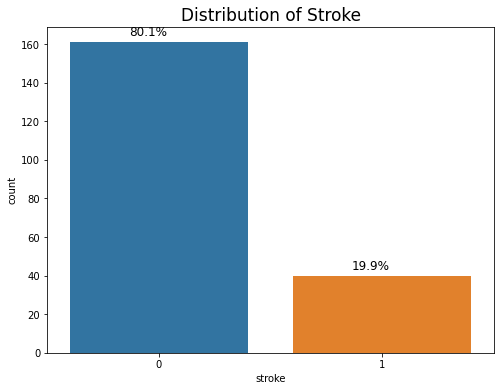

In [5]:
def target(plot, feature):
    total = len(feature)
    for p in plot.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        plot.annotate(percentage, (x, y), size = 12,ha = 'center', va = 'center', xytext = (0, 10), 
                                                                      textcoords = 'offset points')

plt.show()

plt.figure(figsize=(8, 6))
plt.title("Distribution of Stroke",fontsize=17)
plot = sns.countplot(data['stroke'])

target(plot,data.stroke)

In [6]:
# seperate categorical and continous variables for further visualization
categorical_val = []
continous_val = []
for column in data.columns:
    if len(data[column].unique()) <= 13:
        categorical_val.append(column)
    else:
        continous_val.append(column)

In [7]:
continous_val, categorical_val

(['age', 'avg_glucose_level', 'bmi'],
 ['gender',
  'hypertension',
  'heart_disease',
  'ever_married',
  'work_type',
  'Residence_type',
  'smoking_status',
  'stroke'])

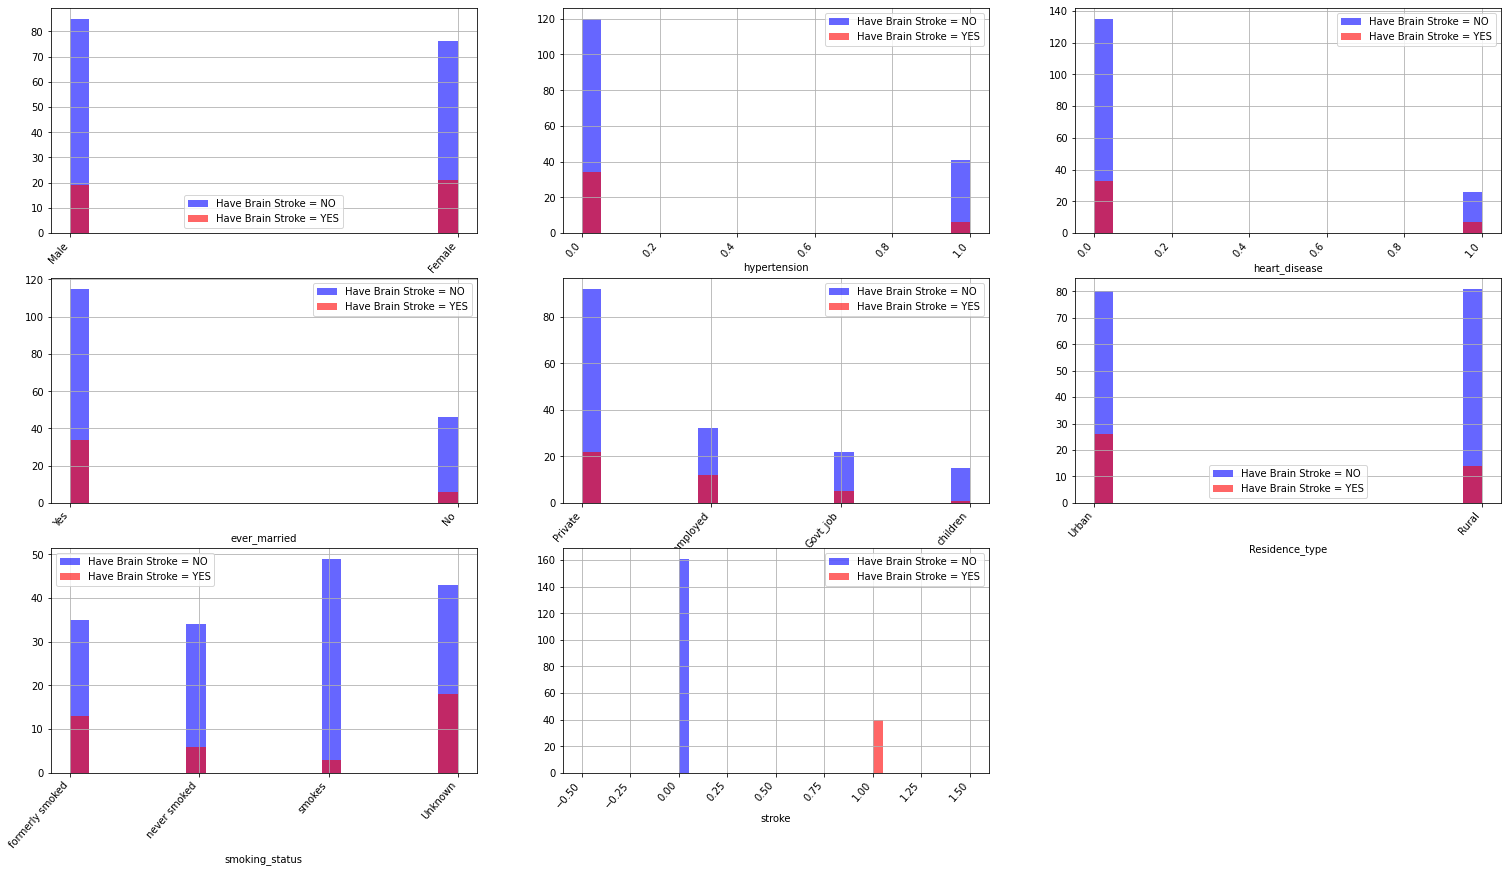

In [8]:
# Target vs. Categorical features

plt.figure(figsize=(26, 24))

for i, column in enumerate(categorical_val, 1):
    plt.subplot(5, 3, i)
    data[data["stroke"] == 0][column].hist(bins=20, color='blue', label='Have Brain Stroke = NO', alpha=0.6)
    data[data["stroke"] == 1][column].hist(bins=20, color='red', label='Have Brain Stroke = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)
    plt.xticks(rotation=49, ha='right',fontsize=10)

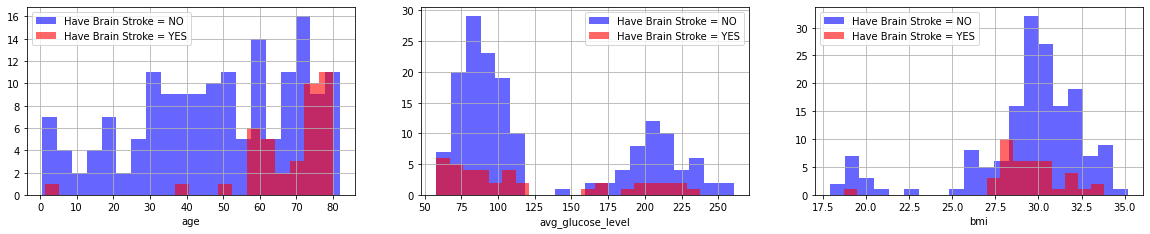

In [9]:
# Target vs. Continuous features

plt.figure(figsize=(20, 20))

for i, column in enumerate(continous_val, 1):
    plt.subplot(5, 3, i)
    data[data["stroke"] == 0][column].hist(bins=20, color='blue', label='Have Brain Stroke = NO', alpha=0.6)
    data[data["stroke"] == 1][column].hist(bins=20, color='red', label='Have Brain Stroke = YES', alpha=0.6)
    plt.legend()
    plt.xlabel(column)

- It looks like married people are candidates for stroke but in fact the stroke cases are strongly correlated with Age. Majority of unmarried people are less than 40 years old and therefore with low risk of stroke
- People who smoke are also candidates for stroke
- There's a high risk of stroke for people with BMI higher than 27.5 and glucose level lower than 150

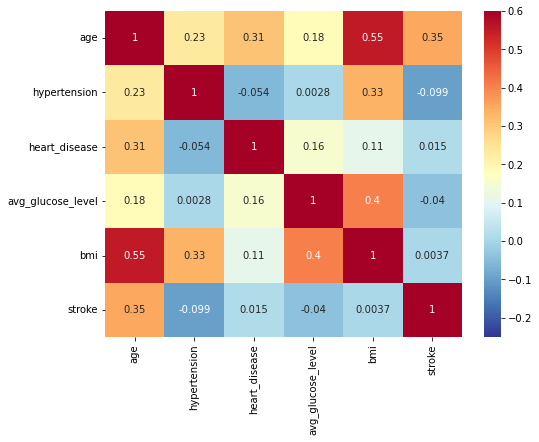

In [10]:
plt.figure(figsize = (8,6))

sns.heatmap(data.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6);

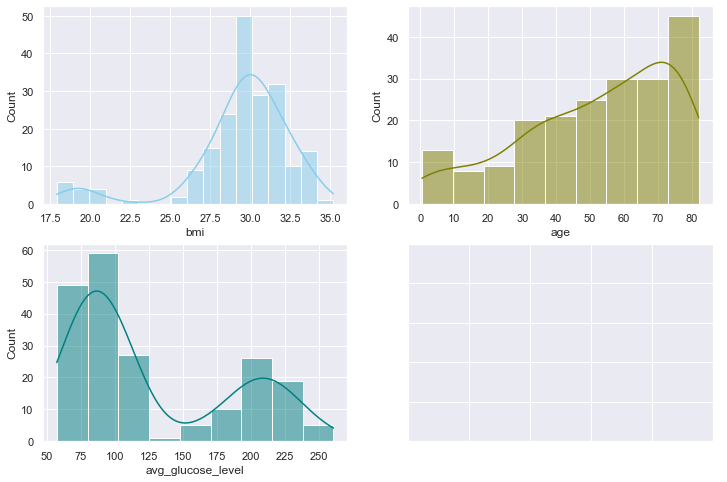

In [11]:
sns.set(style="darkgrid")
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

sns.histplot(data=data, x="bmi", kde=True, color="skyblue",ax=axs[0, 0])
sns.histplot(data=data, x="age", kde=True, color="olive",ax=axs[0, 1])
sns.histplot(data=data, x="avg_glucose_level", kde=True, color="teal",ax=axs[1, 0])
plt.tick_params(labelcolor='none');

Text(0.5, 1.0, 'power 2 of age')

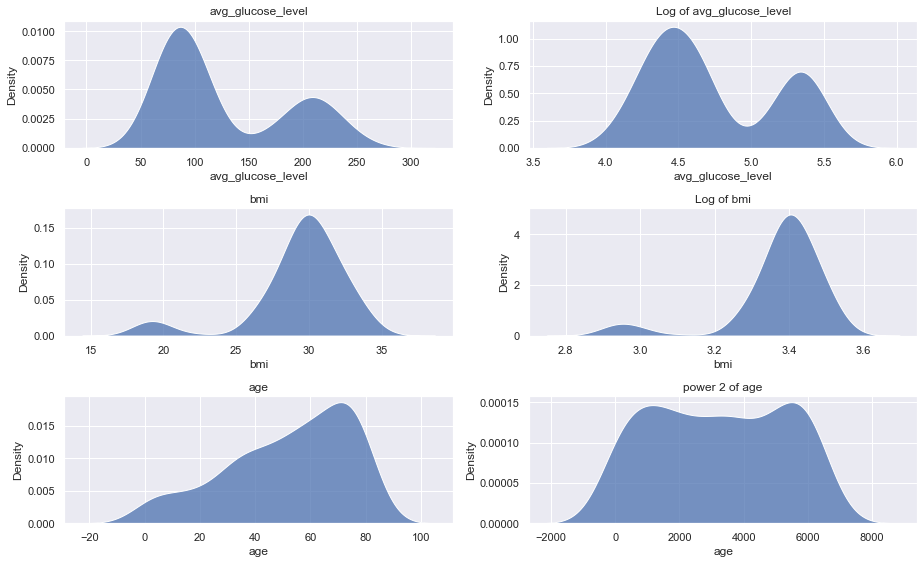

In [12]:
# transform numeric variables to reduce skewness
fig, ax = plt.subplots(3,2, figsize = (13,8), tight_layout = True)

sns.kdeplot(data['avg_glucose_level'], multiple = 'stack', ax = ax[0][0], palette = 'Set1')
ax[0][0].set_title('avg_glucose_level')
sns.kdeplot(np.log(data['avg_glucose_level']), multiple = 'stack', ax = ax[0][1], palette = 'Set1')
ax[0][1].set_title('Log of avg_glucose_level')
                   
sns.kdeplot(data['bmi'], multiple = 'stack', ax = ax[1][0], palette = 'Set1')
ax[1][0].set_title('bmi')
sns.kdeplot(np.log(data['bmi']), multiple = 'stack', ax = ax[1][1], palette = 'Set1')
ax[1][1].set_title('Log of bmi')

sns.kdeplot(data['age'], multiple = 'stack', ax = ax[2][0], palette = 'Set1')
ax[2][0].set_title('age')
sns.kdeplot(np.power(data['age'],2), multiple = 'stack', ax = ax[2][1])
ax[2][1].set_title('power 2 of age')

In [13]:
# perform transformations
data['avg_glucose_level'] = np.log(data['avg_glucose_level'])
data['bmi'] = np.log(data['bmi'])
data['age'] = np.power(data['age'],2)

In [14]:
# One-hot encoding for categorical variables
unwanted = {'stroke'}
 
categorical_val = [ele for ele in categorical_val if ele not in unwanted]

df = pd.get_dummies(data, columns = categorical_val)
df.head()

,age,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,hypertension_0,hypertension_1,heart_disease_0,heart_disease_1,...,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,3721.0,5.309307,3.451751,1,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,1,0
1,3481.0,4.332705,3.409263,1,1,0,1,0,1,0,...,0,1,0,0,1,0,1,0,0,0
2,6084.0,5.392900,3.424228,1,0,1,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0
3,3249.0,5.380266,3.520710,1,0,1,1,0,0,1,...,1,0,0,0,0,1,1,0,0,0
4,3364.0,5.246182,3.446124,1,0,1,1,0,1,0,...,0,1,0,0,1,0,1,0,0,0


In [15]:
X = df.drop('stroke',axis = 1) 
y = df['stroke']   

In [16]:
# apply oversampling since the target feature is imbalanced
oversample = SMOTE()
X_sampled, y_sampled = oversample.fit_resample(X, y)

In [22]:
# Split data - 70% Train and 30% Test
X_train,X_test,y_train,y_test = train_test_split(X_sampled,y_sampled,test_size=0.3,random_state=100,stratify=y_sampled)

In [23]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(225, 21) (225,)
(97, 21) (97,)


In [26]:
# use poniard
pnd = PoniardClassifier(random_state=0)
pnd.setup(X_train, y_train)
pnd.fit()
pnd.show_results()

Target info
-----------
Type: binary
Shape: (225,)
Unique values: 2

Main metric
-----------
roc_auc

Thresholds
----------
Minimum unique values to consider a feature numeric: 22
Minimum unique values to consider a categorical high cardinality: 20

Inferred feature types
----------------------


,numeric,categorical_high,categorical_low,datetime
0,age,,gender_Female,
1,avg_glucose_level,,gender_Male,
2,bmi,,hypertension_0,
3,,,hypertension_1,
4,,,heart_disease_0,
5,,,heart_disease_1,
6,,,ever_married_No,
7,,,ever_married_Yes,
8,,,work_type_Govt_job,
9,,,work_type_Private,


Completed: 100%|██████████| 9/9 [00:04<00:00,  2.22it/s]                     


,test_roc_auc,train_roc_auc,test_accuracy,train_accuracy,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1,fit_time,score_time
RandomForestClassifier,0.942095,1.000000,0.884444,1.000000,0.899979,1.000000,0.867194,1.000000,0.882127,1.000000,0.127673,0.039187
LogisticRegression,0.936364,0.969530,0.862222,0.898889,0.873593,0.911692,0.849407,0.884957,0.860887,0.897934,0.015973,0.012399
LinearSVC,0.935968,0.972838,0.875556,0.904444,0.892539,0.925870,0.858498,0.880537,0.873466,0.902529,0.012599,0.012747
XGBClassifier,0.934190,1.000000,0.840000,1.000000,0.830065,1.000000,0.858103,1.000000,0.842698,1.000000,0.066994,0.016712
HistGradientBoostingClassifier,0.917194,0.999914,0.840000,0.992222,0.843427,0.997753,0.841107,0.986716,0.841925,0.992203,0.094676,0.014481
KNeighborsClassifier,0.912451,0.972777,0.826667,0.905556,0.774099,0.865798,0.928458,0.962320,0.843094,0.911222,0.017250,0.071082
GaussianNB,0.898024,0.936022,0.808889,0.824444,0.779837,0.784270,0.893676,0.917924,0.827190,0.842097,0.016265,0.008467
DecisionTreeClassifier,0.817391,1.000000,0.817778,1.000000,0.835598,1.000000,0.796443,1.000000,0.814007,1.000000,0.015951,0.009595
DummyClassifier,0.500000,0.500000,0.488889,0.502222,0.195556,0.202222,0.400000,0.400000,0.262687,0.268635,0.010702,0.011042


In [28]:
pnd.plot.metrics()

In [40]:
# confusion matrix
predictions = pnd.predict(estimator_names=["RandomForestClassifier"])
pnd.plot.confusion_matrix("RandomForestClassifier")

Completed: 100%|██████████| 1/1 [00:00<00:00,  1.41it/s]     


In [33]:
candidates = ["XGBClassifier", "HistGradientBoostingClassifier","KNeighborsClassifier",
              "LogisticRegression", "RandomForestClassifier","DecisionTreeClassifier"]
pnd.predict_proba(estimator_names=candidates)
pnd.plot.roc_curve(estimator_names=candidates)

Completed: 100%|██████████| 6/6 [00:02<00:00,  2.97it/s]                     


In [34]:
# Feature importance -  RF
pnd.plot.permutation_importance(estimator_name="RandomForestClassifier")

In [38]:
# show a measure of how much each estimator is overfitting when comparing test and train scores.

pnd.plot.overfitness(metric="f1")

In [44]:
# show the average feature partial dependence for a given feature.
# this plot shows how the average predicted probability of having a stroke changes as age increases
# In this case the probability of having a strnke increases as a person gets older
pnd.plot.partial_dependence(estimator_name="RandomForestClassifier",
                            feature="age")